In [1]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

%matplotlib inline

In [2]:
dataset_dir = '/mnt/d/DataSets/whiteboard_class_cutter/'
data_yaml = dataset_dir + '/data.yaml'

In [3]:
model = YOLO("yolov8s.pt")

In [4]:
results = model.train(
    data=str(data_yaml),
    epochs=20,
    imgsz=640,
    batch=6,
    device="cuda",
    workers=6,
    cache=True,
    amp=True,
    patience=5,
    name="whiteboard_det_20640"
)

print(f'Обучение завершено. Путь сохранения: {results.save_dir}')

New https://pypi.org/project/ultralytics/8.3.253 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.240 🚀 Python-3.12.3 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=6, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/mnt/d/DataSets/whiteboard_class_cutter//data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=Fals

In [5]:
weights = 'runs/detect/whiteboard_det_20640/weights/best.pt' 
model = YOLO(str(weights))

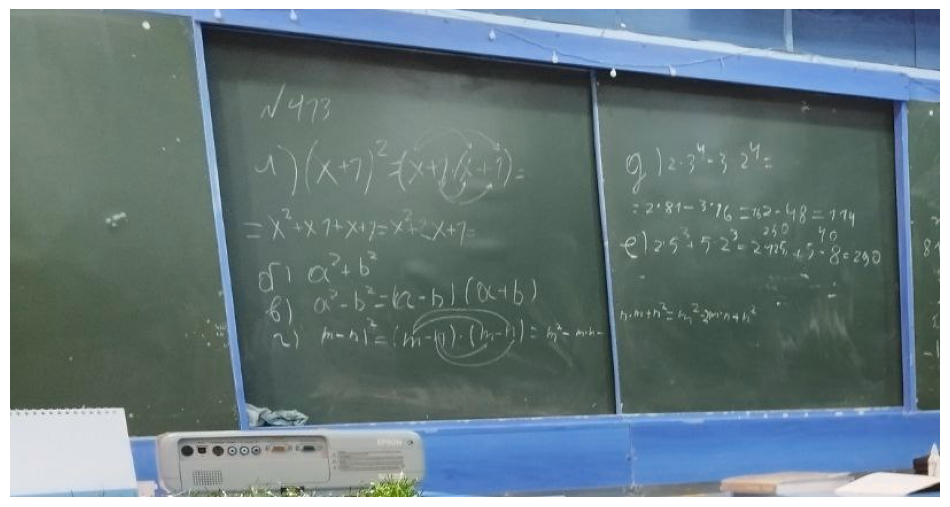

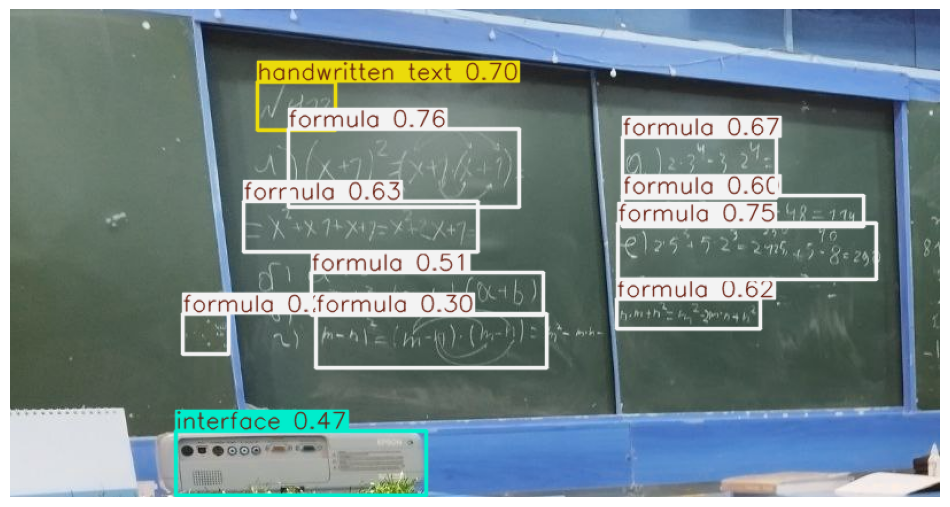

In [7]:
img_path = 'tests/доска с формулами.jpg'
img = cv2.imread(img_path)

pred = model.predict(
    source=img,
    conf=0.25,
    iou=0.5,
    device="cuda",
    save=False,
    verbose=False
)[0]

res = pred.plot()

plt.figure(figsize=(12, 7))
plt.imshow(img)
plt.axis('off')
plt.show()


plt.figure(figsize=(12, 7))
plt.imshow(res)
plt.axis('off')
plt.show()